[View in Colaboratory](https://colab.research.google.com/github/DillipKS/Linguipedia_IIT-BHU/blob/master/Linguipedia_challenge.ipynb)

In [0]:
from __future__ import print_function

from IPython import display
from matplotlib import cm, gridspec, pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
!pip install -U -q gensim

import re, nltk, time, math
import gensim, csv, pickle
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn import linear_model, metrics

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!pip install -U -q PyDrive
!pip install -U -q xlrd
!pip install --upgrade pip

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.0)


In [0]:
# Code to read csv file from Google Drive into colaboratory:

#1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1zssTCHlSKrTj54zi_5uyBqmwIaG3CBUr'})   # replace the id with id of file you want to access
downloaded.GetContentFile('test.csv')  

#3. Read file as panda dataframe
test_df = pd.read_csv('test.csv') 

downloaded = drive.CreateFile({'id':'1OvgF_veQ9fUbz4JYp0Kg5SJyHg90cwz1'})
downloaded.GetContentFile('train.csv')  
train_df = pd.read_csv('train.csv')

In [5]:
#Visualise training data

print(train_df.head())

   id  label                                              tweet
0   1      0  #fingerprint #Pregnancy Test https://goo.gl/h1...
1   2      0  Finally a transparant silicon case ^^ Thanks t...
2   3      0  We love this! Would you go? #talk #makememorie...
3   4      0  I'm wired I know I'm George I was made that wa...
4   5      1  What amazing service! Apple won't even talk to...


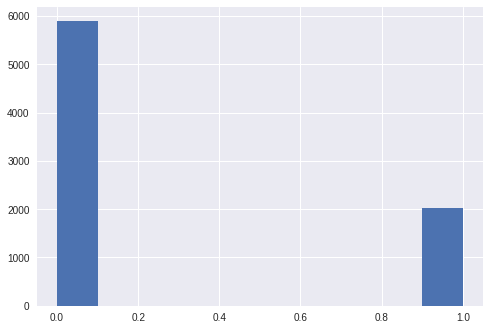

In [6]:
train_df['label'].hist()

In [0]:
def preprocess(dataframe):
    '''
    Preprocess the tweets in train.csv and store it into a csv file with ID and Label
    '''
    columns=['id','label', 'tweet']    
    tweets = []
    
    for row in dataframe.itertuples(index=True, name='Pandas'):
        mystring = re.sub('[^A-Za-z]+', ' ', row[3])
        text = ' '.join([word.lower() for word in mystring.split() if word not in stop_words and len(word)>=2])
        tweets.append((row[1], row[2], text))
    
    tweets_df = pd.DataFrame.from_records(tweets, columns=columns)
    tweets_df.to_csv('tweets_clean.csv', index=False)
    files.download('tweets_clean.csv')
    
    return tweets_df

In [0]:
def test_preprocess(dataframe):
    '''
    Preprocess the tweets in test.csv and store it into a csv file with ID and Label
    '''
    columns=['id', 'tweet']
    tweets = []
    for row in dataframe.itertuples(index=True, name='Pandas'):
        mystring = re.sub('[^A-Za-z]+', ' ', row[2])
        text = ' '.join([word.lower() for word in mystring.split() if word not in stop_words and len(word)>=2])
        tweets.append((row[1], text))
    
    tweets_df = pd.DataFrame.from_records(tweets, columns=columns)
    tweets_df.to_csv('tweets_test.csv', index=False)
    files.download('tweets_test.csv')
    
    return tweets_df

In [0]:
def test_data_prediction(X_new, ID_test):
    '''
    Predict the class labels for held out test data and print into a csv file
    '''
    X_new_vec = vectorizer.transform(X_new)
    pred = logreg.predict(X_new_vec)

    columns=['id', 'label']
    predictions = []
    for i in range(len(ID_test)):
        predictions.append((ID_test[i], pred[i]))

    pred_df = pd.DataFrame.from_records(predictions, columns=columns)
    pred_df.to_csv('submission.csv', index=False)
    files.download('submission.csv')
    

In [10]:
print('Data processing')
start = time.time()

tweets_df = preprocess(train_df)
tweets_df = tweets_df.reindex(np.random.permutation(tweets_df.index))
Y = tweets_df.loc[:, 'label']
X = tweets_df.loc[:, 'tweet']

end = time.time()
print(end-start)

Data processing
3.3041350841522217


In [11]:
print(X.head())
print(Y.head())

7101    hey samsung galaxy new phone whitefrost galaxy...
7801    happy new year beaver eggtooth http newsdict j...
6905              living phone lifestyle do not recommend
4942    samsung iii samsung smartphone nice cool good ...
4158    next yr watching apple cup everett washington ...
Name: tweet, dtype: object
7101    0
7801    0
6905    1
4942    0
4158    0
Name: label, dtype: int64


In [12]:
split_per = 0.75    # Training-Test split ratio
num_ex = len(Y)
split = int(split_per * num_ex)

print('TF-IDF embeddings')
start = time.time()

vectorizer = TfidfVectorizer(max_features=8000)
tf_idf_matrix = vectorizer.fit_transform(X)
#pickle.dump(tf_idf_matrix, open("tfidf_feature.pkl","wb"))

end = time.time()
print(end-start)

TF-IDF embeddings
0.17155838012695312


In [13]:
print('Logistic Regression model training')
start = time.time()

X_train = tf_idf_matrix[:split]
X_test = tf_idf_matrix[split:]
Y_train, Y_test = Y[:split], Y[split:]

logreg = linear_model.LogisticRegression(C=1)         # C = Regularization coefficient
logreg.fit(X_train,Y_train)
#pickle.dump(logreg, open("logreg_model.pkl","wb"))

end = time.time()
print(end-start)


Logistic Regression model training
0.023395538330078125


In [14]:
print('Prediction')

pred_train = logreg.predict(X_train)
pred_test = logreg.predict(X_test)

# Weighted F1 score
accuracy_train = f1_score(Y_train, pred_train, average='weighted')
accuracy_test = f1_score(Y_test, pred_test, average='weighted')

print("Training Weighted F1 score: %s" % accuracy_train)
print("Test Weighted F1 score: %s" % accuracy_test)

Prediction
Training Weighted F1 score: 0.929607713038949
Test Weighted F1 score: 0.8979502343884932


AxesSubplot(0.125,0.125;0.775x0.755)


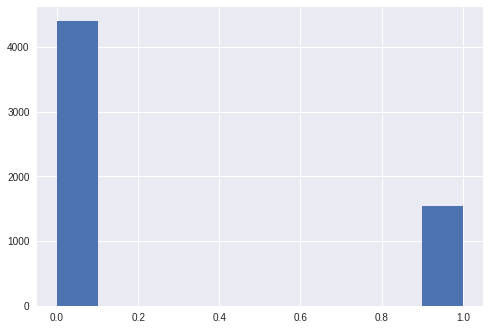

In [15]:
print(Y_train.hist())

AxesSubplot(0.125,0.125;0.775x0.755)


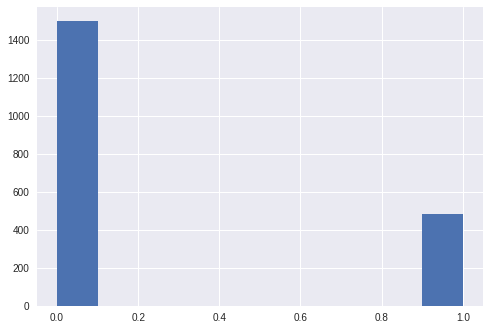

In [16]:
print(Y_test.hist())

In [17]:
print('Test Data processing')
start = time.time()

tweets_test_df = test_preprocess(test_df)
ID_test = tweets_test_df.loc[:, 'id']
X_new = tweets_test_df.loc[:, 'tweet']

end = time.time()
print(end-start)

Test Data processing
2.807187080383301


In [18]:
print('Test Data prediction')
test_data_prediction(X_new, ID_test)

Test Data prediction
